In [1]:
import jax 
import ticktack
import matplotlib.pyplot as pyplot

In [2]:
model = ticktack.load_presaved_model("Guttler15", production_rate_units="atoms/cm^2/s")
model.compile()

MATRIX = model._matrix
PROJECTION = model._production_coefficients

del model

In [3]:
def load(filename: str):
    """
    A custom `JAX` file loading protocol designed to be very quick and return a value that is `JAX` transformable. 
    
    Parameters:
        filename: String -> The file address of the data
    Returns:
        DeviceArray -> The data in column major order
    """
    with open(filename) as data:    # Opening the data file
        _ = next(data)              # Header row for the data 

        data = jax.numpy.array(
            [row.strip().split(",") for row in data], 
            dtype=jax.numpy.float64
        )
        
        return data.T

In [4]:
time_out = jax.numpy.linspace(0, 10, 100)

In [5]:
multiply = jax.jit(jax.vmap(jax.numpy.multiply, in_axes=(None, 0)))
matrix_multiply = jax.jit(jax.vmap(jax.numpy.matmul, in_axes=(0, None)))

In [6]:
eigenvals, eigenvecs = jax.numpy.linalg.eig(MATRIX)
eigenvecs, eigenvals = eigenvecs.real, eigenvals.real
inverse = jax.numpy.linalg.inv(eigenvecs)
initial_position = 1.0 / jax.numpy.linalg.norm(PROJECTION) * PROJECTION

In [7]:
@jax.jit
def fundamental_matrix(time_out, /, eigenvecs=eigenvecs, eigenvals=eigenvals, inverse=inverse):
    """
    This constructs the right hand side of the fundamental solution matrix. It is vectorised and so returns a three dimensional array with the third dimension spanning the time series implied by `time_out`.

    Parameters:
    -----------
    : time_out :  The time series over which the fundamental matrix is to be calculated
    : eigenvecs : The eigenvectors of the transfer matrix
    : eigenvals : The eigenvalues of the transfer matrix
    : inverse : The inverse of the eigenvectors of the transfer matrix. This could be calculated internally but since the evaluation is only required once it is passed as an argument.

    Returns:
    --------
    : DeviceArray : The fundamental solution matrix evaluated over the time series implied by `time_out`
    """
    # So I need to implement the translation of the time series back onto 0
    exponents = jax.numpy.exp(multiply(eigenvals, time_out))
    transition_matrix = multiply(eigenvecs, exponents)
    transition_matrix = matrix_multiply(transition_matrix, inverse)
    return transition_matrix

In [8]:
@jax.jit
def analytic_template(time_out, /, initial_poisition=initial_position):
    """
    Determines the analytic solution of an impulse response function over the time series provided by `time_out`.

    Parameters:
    -----------
    : time_out : The time series at which the analytic solution is to be evaluated
    : inverse : The inverse of the eigenvectors of the transfer matrix
    
    """
    transition_matrix = fundamental_matrix(time_out - time_out.min())
    return matrix_multiply(transition_matrix, initial_poisition)

In [9]:
intcal = load("/home/jordan/Documents/ticktack/src/data/datasets/IntCal20/Intcal20.csv")

In [10]:
@jax.jit
def design_matrix(time_series):
    constant = jax.numpy.ones((time_series.shape), dtype=jax.numpy.float64)
    analytic = analytic_template(time_series)[:, 1]
    return jax.numpy.stack([constant, time_series, analytic])

In [75]:
@jax.jit
def regression(window_start):
    in_window = (intcal[0] > window_start) & (intcal[0] < window_start + 50)
    data_in_window = in_window * intcal
    masked_matrix = design_matrix(data_in_window[0])
    masked_inverse = jax.numpy.linalg.pinv(masked_matrix.T)
    return masked_inverse @ intcal[1]

In [82]:
time_series = jax.numpy.sort(intcal[0])

In [79]:
parameters = jax.numpy.array([
    regression(start) for start in time_series
])

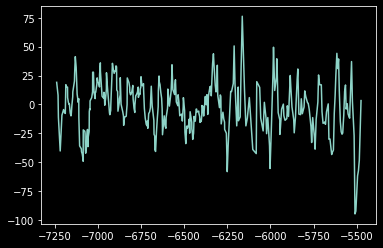

In [91]:
pyplot.plot(time_series[:500], parameters[:500, 2])